In [1]:
import torch
from torchvision import transforms,datasets
from efficientnet_pytorch import EfficientNet
from torch.utils.data import DataLoader
import numpy as np
import cv2
from torch import nn,optim
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt

In [2]:
model_name = 'efficientnet-b0'
image_size = EfficientNet.get_image_size(model_name) # 224

In [3]:
tfms = transforms.Compose([transforms.Resize(image_size), transforms.CenterCrop(image_size), 
                           transforms.ToTensor(),
                           transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),])

In [4]:
model = EfficientNet.from_pretrained(model_name,in_channels=3, num_classes=5)

Loaded pretrained weights for efficientnet-b0


In [5]:
train_imgs=datasets.ImageFolder(r'E:\A_py_project\EfficientNet-PyTorch\examples\simple\data\newData\train',transform=tfms)
test_imgs=datasets.ImageFolder(r'E:\A_py_project\EfficientNet-PyTorch\examples\simple\data\newData\test',transform=tfms)

In [6]:
# import json
# class_to_idx=train_imgs.class_to_idx
# file="name.json"
# with open(file,'w') as f:
#     json.dump(class_to_idx,f)



In [6]:
train_loader=DataLoader(dataset=train_imgs,shuffle=True,batch_size=64,pin_memory=True)
test_loader=DataLoader(dataset=test_imgs,shuffle=False,batch_size=64,pin_memory=True)

In [7]:
for param in model.parameters():
    param.requires_grad=False
for param in model._fc.parameters():
    param.requires_grad=True

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=

In [9]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func=nn.CrossEntropyLoss().to(device)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer=optimizer, step_size=10, gamma=0.5)

In [10]:
loss_train=[]
loss_valid=[]
acc=[]
def train(epoch):
    loss=0
    for step,(x,y) in enumerate(train_loader):
        # gpu计算
        x=x.to(device)
        y=y.to(device)
        output=model(x)
        loss=loss_func(output,y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if step%100==0:
            print('Train Epoch:{}[{}/{}({:.0f})]\tLoss:{:.6f}'.format(
                epoch,step*len(x),len(train_loader.dataset),
                100.*step/len(train_loader),loss.item()))
    loss_train.append(loss.item())
def test():
    model.eval()
    test_loss=0
    correct=0
    for step,(x,y) in enumerate(test_loader):
        # gpu计算
        x = x.to(device)
        y = y.to(device)
        output=model(x)
        test_loss+=loss_func(output,y).item()
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(y.data.view_as(pred)).cpu().sum()
        test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    loss_valid.append(test_loss*len(test_loader.dataset))
    acc.append(100. * correct / len(test_loader.dataset))

In [12]:
for epoch in range(10):
    train(epoch)
    test()
# torch.save({'casia_efficient': model.state_dict()}, 'casia_efficient.pth')


Train Epoch:0[0/66(0)]	Loss:0.553868

Test set: Average loss: 0.0220, Accuracy: 26/30 (87%)

Train Epoch:1[0/66(0)]	Loss:0.539585

Test set: Average loss: 0.0215, Accuracy: 26/30 (87%)

Train Epoch:2[0/66(0)]	Loss:0.519212

Test set: Average loss: 0.0209, Accuracy: 27/30 (90%)

Train Epoch:3[0/66(0)]	Loss:0.517222

Test set: Average loss: 0.0200, Accuracy: 27/30 (90%)

Train Epoch:4[0/66(0)]	Loss:0.500591

Test set: Average loss: 0.0193, Accuracy: 27/30 (90%)

Train Epoch:5[0/66(0)]	Loss:0.490294

Test set: Average loss: 0.0188, Accuracy: 27/30 (90%)

Train Epoch:6[0/66(0)]	Loss:0.481820

Test set: Average loss: 0.0184, Accuracy: 27/30 (90%)

Train Epoch:7[0/66(0)]	Loss:0.477859

Test set: Average loss: 0.0179, Accuracy: 27/30 (90%)

Train Epoch:8[0/66(0)]	Loss:0.462625

Test set: Average loss: 0.0176, Accuracy: 27/30 (90%)

Train Epoch:9[0/66(0)]	Loss:0.452302

Test set: Average loss: 0.0173, Accuracy: 27/30 (90%)



In [12]:
loss_train=np.array(loss_train)
loss_valid=np.array(loss_valid)
x_loss=np.vstack((loss_train,loss_valid))


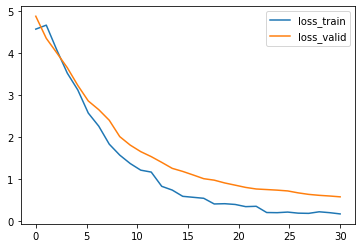

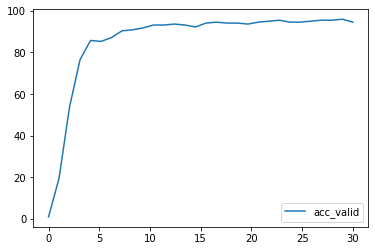

In [15]:
x=np.linspace(0,30,30)
plt.plot(x,x_loss[0],label="loss_train")
plt.plot(x,x_loss[1],label="loss_valid")
plt.legend()
plt.show()
plt.plot(x,acc,label="acc_valid")
plt.legend()
plt.show()